# Titanic Dataset

## Setup

### Include all libraries

Include all required libraries and output the version information:

In [1]:
import os
import getpass
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
%matplotlib inline

np.__version__, pd.__version__, sklearn.__version__, sns.__version__

('1.23.4', '1.5.2', '1.1.3', '0.12.0')

In [2]:
%load_ext version_information
%version_information

Software versions
Python 3.10.8 64bit [GCC 10.2.1 20210110]
IPython 8.6.0
OS Linux 5.10.104 linuxkit aarch64 with glibc2.31
Mon Nov 28 13:54:21 2022 UTC

### Download dataset

Please manually download the dataset `train.csv` from [Kaggle](https://www.kaggle.com/competitions/titanic/data) (after sign-in) into the folder `data`.

In [3]:
raw_train_csv_path = 'data/train.csv'

while not os.path.isfile(raw_train_csv_path):
    print('Please sign in to Kaggle and download the dataset `train.csv` into the folder `data`.')
    input('Press Enter to continue...')

raw_df = pd.read_csv(raw_train_csv_path)

## Data preparation

Print the first 5 records:

In [4]:
raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
raw_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Print the shape of the records:

In [5]:
raw_df.shape

(891, 12)

Print all column names:

In [6]:
raw_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Print all data types:

In [7]:
raw_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In which columns are how many `null` values?

In [8]:
for column in raw_df:
    if (raw_df[column].isnull().sum()):
        print(f'{column}: {raw_df[column].isnull().sum()} null values')

Age: 177 null values
Cabin: 687 null values
Embarked: 2 null values


Preparation of the dataset:

In [9]:
def prepare_raw_df(df):
    # Remove unneeded columns 
    df = df.drop(['Name', 'Ticket'], axis=1)
    # Remove columns with missing values
    df = df.drop(['Cabin'], axis=1)
    # Remove the two records with missing `Embarked` values
    df = df.dropna(axis=0, subset=['Embarked'])
    # Calculate missing `Age` values
    df['Age'] = df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    # Replace categorical values with dummy values
    df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2})
    # Reorder columns
    df = df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]
    # Rename columns
    df = df.rename(columns={ 'PassengerId': 'id', 'Pclass': 'ticket_class', 'Sex': 'sex', 'Age': 'age',
                             'SibSp': 'num_of_siblings_and_spouses', 'Parch': 'num_of_parents_and_children', 
                             'Fare': 'fare', 'Embarked': 'port_of_embarkation', 'Survived': 'survived'})
    return df

df = prepare_raw_df(raw_df)
df.head()

,id,ticket_class,sex,age,num_of_siblings_and_spouses,num_of_parents_and_children,fare,port_of_embarkation,survived
0,1,3,0,22.0,1,0,7.2500,0,0
1,2,1,1,38.0,1,0,71.2833,1,1
2,3,3,1,26.0,0,0,7.9250,0,1
3,4,1,1,35.0,1,0,53.1000,0,1
4,5,3,0,35.0,0,0,8.0500,0,0


## Training

Create the X and y values and split the data set into training and test data:

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(['id', 'survived'], axis=1)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

Fit and validate the model and plot the ROC curve and confusion matrix:

Accuracy = 0.8052434456928839
Precision = 0.7378640776699029
Recall = 0.7524752475247525
F1-Score = 0.7450980392156863


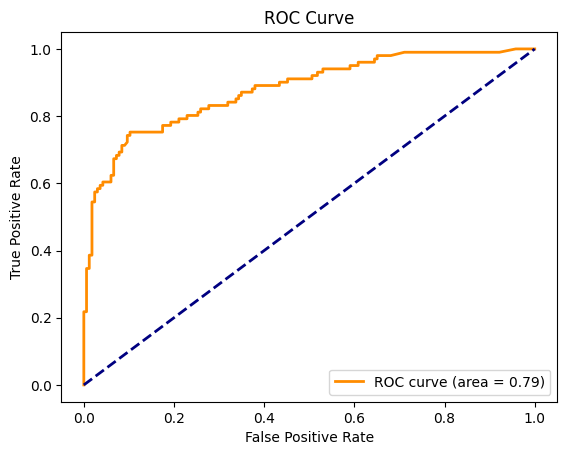

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


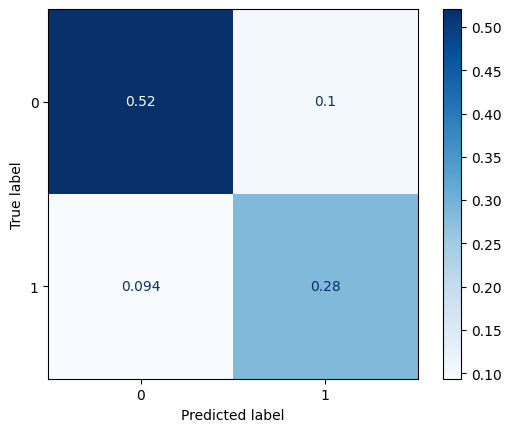

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_confusion_matrix

def plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc):
    lw = 2
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def validate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy = {}'.format(accuracy))

    precision = precision_score(y_test, y_pred)
    print('Precision = {}'.format(precision))

    recall = recall_score(y_test, y_pred)
    print('Recall = {}'.format(recall))

    f1Score = f1_score(y_test, y_pred)
    print('F1-Score = {}'.format(f1Score))

    roc_auc = roc_auc_score(y_test, y_pred) 
    y_prob = model.predict_proba(X_test)  
    y_prob = y_prob[:, 1]  
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob) 
    plot_roc_curve(false_positive_rate, true_positive_rate, roc_auc)

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'all')

from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
validate_model(model, X_test, y_test)

## Monitoring

### Superwise

[Website](https://superwise.ai/) | [Documentation](https://docs.superwise.ai/docs) | [Portal](https://portal.superwise.ai/)

#### Setup

Create a new secret in the Superwise portal and enter the client id and the secret:

In [14]:
from superwise import Superwise

print("Enter your Superwise Client ID...")
os.environ['SUPERWISE_CLIENT_ID'] = input()

print("Enter your Superwise Secret...")
os.environ['SUPERWISE_SECRET'] = getpass.getpass()

sw_client = Superwise()

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Enter your Superwise Client ID...
Enter your Superwise Secret...


Create a new project and a model:

In [20]:
from superwise.models.project import Project
from superwise.models.model import Model

# Create a new project
project = Project(name=f'Titanic Project {datetime.today().strftime("%Y-%m-%d")}', description='Project for the Titanic model.')
project = sw_client.project.create(project)
sw_project_id = project.id
print('Superwise Project ID:', sw_project_id)

# Create a new model
sw_model = Model(name=f'Titanic Model  {datetime.today().strftime("%Y-%m-%d")}', description='The Titanic model.', project_id=sw_project_id)
sw_model = sw_client.model.create(sw_model)
sw_model_id = sw_model.id
print('Superwise Model ID:', sw_model_id)

Superwise Project ID: 6
Superwise Model ID: 17


Take a look: https://portal.superwise.ai/

Next, we have to upload our dataset.

> Uploading a dataset is an essential step when you create a version in the Superwise platform. It acts as a model baseline and is used by Superwise as reference data when carrying out analytics and pre-configured metrics.

Prepare the training data for the upload to Superwise and create a dataset and version:

In [21]:
from superwise.models.dataset import Dataset
from superwise.models.version import Version
from superwise.resources.superwise_enums import DataEntityRole, FeatureType, DatasetType

def sw_prepare_train_data(df):
    df_copy = df.copy(deep=True)
    df_copy['prediction'] = model.predict(df.drop(['id', 'survived'], axis=1))
    df_copy['prediction_probability'] = np.max(model.predict_proba(X), axis=1)
    df_copy['timestamp'] = datetime.today().strftime('%Y-%m-%d %H:%M:%S.%f')
    return df_copy

sw_train_csv_path = 'data/sw_train.csv'

sw_df = sw_prepare_train_data(df)
sw_df.to_csv(sw_train_csv_path, index=False)

# Create a new dataset
sw_dataset = Dataset(name=f'Training Dataset', 
                     files=[sw_train_csv_path], 
                     project_id=sw_project_id,
                     type=DatasetType.TRAIN.value,
                     roles={
                        DataEntityRole.LABEL.value: ['survived'],
                        DataEntityRole.PREDICTION_VALUE.value: ['prediction', 'prediction_probability'],
                        DataEntityRole.TIMESTAMP.value: 'timestamp',
                        DataEntityRole.ID.value: 'id'
                     },
                     dtypes={
                        'sex': FeatureType.CATEGORICAL.value,
                        'prediction': FeatureType.BOOLEAN.value,
                        'survived': FeatureType.BOOLEAN.value
                    })
sw_dataset = sw_client.dataset.create(sw_dataset)
sw_dataset_id = sw_dataset.id
print('Superwise Dataset ID:', sw_dataset_id)

# Create a new version
sw_version = Version(name=datetime.today().strftime('%Y-%m-%d-%H-%M-%S'), model_id=sw_model_id, dataset_id=sw_dataset_id)
sw_version = sw_client.version.create(sw_version)
sw_version_id = sw_version.id
print('Superwise Version ID:', sw_version_id)

# Upload the new version
sw_version = sw_client.version.activate(sw_version_id)

Superwise Dataset ID: 16
Superwise Version ID: 26


Take a look: https://portal.superwise.ai/

Create two segments for the genders in the portal.

Make a prediction and log the result in Superwise:

In [22]:
def sw_log_prediction(input_dict: dict, prediction: int, prediction_probability: float):
    record = {i[0]: i[1] for i in input_dict.items()}
    record['id'] = datetime.today().strftime('%Y%m%d%H%M%S%f')
    record['survived'] = None
    record['prediction'] = prediction
    record['prediction_probability'] = prediction_probability
    record['timestamp'] = datetime.today().strftime('%Y-%m-%d %H:%M:%S.%f')
    sw_client.transaction.log_records(
        model_id = sw_model_id, 
        version_id = sw_version_id, 
        records = [record]
    )['transaction_id']

def predict(model, input_dict: dict):
    input_df = pd.DataFrame(data={i[0]: [i[1]] for i in input_dict.items()})
    return int(model.predict(input_df)[0]), float(np.max(model.predict_proba(input_df), axis=1)[0])

prediction_input = {
    'ticket_class': 1,
    'sex': 1,
    'age': 20,
    'num_of_siblings_and_spouses': 0,
    'num_of_parents_and_children': 0,
    'fare': 5,
    'port_of_embarkation': 1
}
prediction, prediction_probability = predict(model, prediction_input)
print(prediction, prediction_probability)
sw_log_prediction(prediction_input, prediction, prediction_probability)

1 0.8294118046760559


Passing version name will be deprecated soon, pass version ID instead


#### Interactive demo

Send requests to the web server and submit the input and predictions directly to Superwise:

**Task**: Can you figure out which parameters are most relevant based on various inputs and predictions?

In [23]:
from flask import Flask
from flask_restx import Api, Resource, reqparse

flask_app = Flask(__name__)

flask_api = Api(flask_app)

flask_request_parser = reqparse.RequestParser()
flask_request_parser.add_argument('ticket_class', type=int, help='Ticket class: 1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower)', required=True)
flask_request_parser.add_argument('sex', type=int, help='Sex: 0 = Man, 1 = Woman', required=True)
flask_request_parser.add_argument('age', type=int, help='Age in years', required=True)
flask_request_parser.add_argument('num_of_siblings_and_spouses', type=int, help='Number of siblings and spouses aboard the Titanic', required=True)
flask_request_parser.add_argument('num_of_parents_and_children', type=int, help='Number of parents and children aboard the Titanic', required=True)
flask_request_parser.add_argument('fare', type=float, help='Passenger fare', required=True)
flask_request_parser.add_argument('port_of_embarkation', type=int, help='Port of embarkation: 0 = Southampton, 1 = Cherbourg, 2 = Queenstown', required=True)

@flask_api.route('/predict')
class PredictionResource(Resource):
    @flask_api.doc(parser=flask_request_parser)
    def post(self):
        args = flask_request_parser.parse_args()
        # Make prediction
        prediction, prediction_probability = predict(model, args)
        print()
        print('> Input:', args)
        print('> Prediction:', prediction)
        print('> Probability:', prediction_probability)
        print()
        # Log production predictions
        sw_log_prediction(prediction_input, prediction, prediction_probability)
        return { 'prediction': prediction, 'prediction_probability': prediction_probability }

flask_app.run(port=5100)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5100
Press CTRL+C to quit
127.0.0.1 - - [28/Nov/2022 14:12:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2022 14:12:03] "GET /swaggerui/droid-sans.css HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2022 14:12:03] "GET /swaggerui/swagger-ui.css HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2022 14:12:03] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2022 14:12:03] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2022 14:12:06] "GET /swaggerui/favicon-16x16.png HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2022 14:12:06] "GET /swagger.json HTTP/1.1" 200 -



> Input: {'ticket_class': 2, 'sex': 1, 'age': 20, 'num_of_siblings_and_spouses': 0, 'num_of_parents_and_children': 0, 'fare': 8.0, 'port_of_embarkation': 1}
> Prediction: 1
> Probability: 0.9891325831413269



Passing version name will be deprecated soon, pass version ID instead
127.0.0.1 - - [28/Nov/2022 14:13:49] "POST /predict?ticket_class=2&sex=1&age=20&num_of_siblings_and_spouses=0&num_of_parents_and_children=0&fare=8&port_of_embarkation=1 HTTP/1.1" 200 -


Analyze the requests on the Superwise Analytics page and filter by the segments.

Also, look at the available metrics and create policies.

## Evaluation

Plot of correlations between `survived` and the rest of the columns:

<AxesSubplot: >

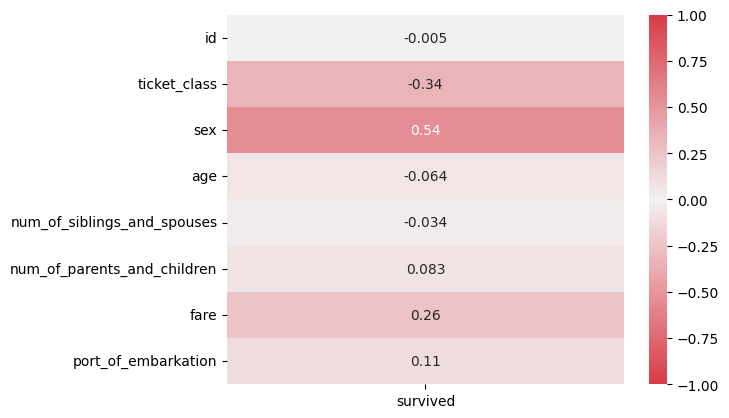

In [ ]:
corr = df.corrwith(df['survived']).drop(['survived'])
corr_df = pd.DataFrame({ 'survived': corr }, index=df.columns[:-1])
cmap = sns.diverging_palette(10,10, as_cmap=True)
sns.heatmap(corr_df, annot=True, cmap=cmap, vmin=-1, vmax=1)

## Bonus

### WhyLabs

In [33]:
# Set your org-id here - should be something like "org-xxxx"
print("Enter your WhyLabs Org ID...") 
os.environ["WHYLABS_DEFAULT_ORG_ID"] = input()

# Set your datased_id (or model_id) here - should be something like "model-xxxx"
print("Enter your WhyLabs Dataset ID...")
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input()

# Set your API key here
print("Enter your WhyLabs API key...")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()

Enter your WhyLabs Org ID...
Enter your WhyLabs Dataset ID...
Enter your WhyLabs API key...


Split data into daily batches and upload:

In [35]:
from datetime import timezone, timedelta
import whylogs as why
from whylogs.api.writer.whylabs import WhyLabsWriter

wl_writer = WhyLabsWriter()

def wl_prepare_train_data(df):
    df_copy = df.copy(deep=True)
    df_copy.rename(columns={ 'survived': 'output_survived' }, inplace=True)
    df_copy['output_prediction'] = model.predict(df.drop(['id', 'survived'], axis=1))
    df_copy['output_score'] = np.max(model.predict_proba(X), axis=1)
    return df_copy

def wl_log_data(df, timestamp):
    # wl_results = why.log_classification_metrics(
    #     df,
    #     target_column = 'output_survived',
    #     prediction_column = 'output_prediction',
    #     score_column='output_score'
    # )
    # wl_profile = wl_results.profile()
    # wl_profile.set_dataset_timestamp(timestamp)
    # wl_results.writer("whylabs").write()
    wl_profile = why.log(df).profile()
    wl_profile.set_dataset_timestamp(timestamp)
    wl_writer.write(profile=wl_profile.view())
    print('Logged profile for {}'.format(timestamp))

def add_random_column_outliers(df, column, num_of_outliers):
    df = df.copy(deep=True)
    df = df.reset_index()
    number_of_rows = df.shape[0]
    for i in range(num_of_outliers):
        random_row = np.random.randint(0, number_of_rows)
        df.loc[random_row, column] += round(np.random.uniform(low=150.0, high=200.0), 2)
    return df

wl_df = wl_prepare_train_data(df)
wl_df_splits = np.array_split(wl_df, 7)

for day, df_split in enumerate(wl_df_splits):
    if day == 2:
        # df_split = add_random_column_outliers(df_split, 'age', 30)
        df_split['age'] += 50
    timestamp = datetime.now(timezone.utc) - timedelta(days=day + 1)
    wl_log_data(df_split, timestamp)

`profile` is deprecated as an argument to `write`; use `file` instead.


Logged profile for 2022-11-27 14:54:20.861609+00:00
Logged profile for 2022-11-26 14:54:22.568204+00:00


`profile` is deprecated as an argument to `write`; use `file` instead.


Logged profile for 2022-11-25 14:54:23.645065+00:00
Logged profile for 2022-11-24 14:54:24.716373+00:00
Logged profile for 2022-11-23 14:54:25.786980+00:00


A profile being uploaded to WhyLabs has a dataset_timestamp of 2022-11-21 14:54:27.896987+00:00 which is older than 7 days compared to 2022-11-28 14:54:27.925508+00:00. These profiles should be processed within 24 hours.


Logged profile for 2022-11-22 14:54:26.885484+00:00
Logged profile for 2022-11-21 14:54:27.896987+00:00
